# EDA for NYC Collision Data


### Key Questions
- Fields of use
- Handling missing Data
- Gaps between data
- EDA for collisions, deaths and injuries
- Are many collisions missing location data? 


### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

##References-
1. https://github.com/rathodmansi/NYC-VehicularCollision-Prediction
2.  https://github.com/drakearch/kaggle-courses/blob/master/geospatial_analysis/05-proximity-analysis.ipynb
3. https://github.com/ray310/NYC-Vehicle-Collisions/blob/main/1-profiling-raw-collision-data.ipynb
4. https://github.com/saikrishna-kanneti/NewYork-Vehicle-Collision-Geospatial-analysis/blob/master/NYPD_motor_vehicle_collisions.ipynb
5. https://github.com/rohitgeo/geonotebooks


In [ ]:
!pip install panda-helper
!pip install pysal
!pip install geopandas
from datetime import datetime
import math
import matplotlib.pyplot as plt
import pandas as pd
import pandahelper.reports as ph
import scipy.stats
import geopandas as gpd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pysal
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
import graphviz 
%matplotlib inline
sns.set_style("whitegrid")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 28.5 MB/s 
     |████████████████████████████████| 243 kB 56.8 MB/s 
     |████████████████████████████████| 220 kB 75.0 MB/s 
     |████████████████████████████████| 147 kB 51.3 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 84 kB 4.8 MB/s 
     |████████████████████████████████| 2.4 MB 55.6 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 60 kB 9.4 MB/s 
     |████████████████████████████████| 5.7 MB 36.0 MB/s 
     |████████████████████████████████| 41 kB 729 kB/s 
     |████████████████████████████████| 1.0 MB 43.2 MB/s 
     |████████████████████████████████| 179 kB 63.3 MB/s 
     |████████████████████████████████| 2.1 MB 49.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Use this command for compelete data set
data = pd.read_csv(
    "/content/drive/MyDrive/spatial project/Motor_Vehicle_Collisions_-_Crashes (1).csv", dtype={"ZIP CODE": "object"}, low_memory=False,
)  

#Download from here: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95 and save it on your drive
# Mount your drive, provide your path to run it


In [ ]:
# Run this block for Sampling the dataset else skip (The complete dataset is large which might make running the following commands longer if you're just testing
data = data[0:25000]

# Preparing Data for visualizations and EDA

In [ ]:
ph.DataFrameProfile(data)

DataFrame-Level Info
----------------------  -----------
DF Shape                (25000, 29)
Duplicated Rows         0

Series Name                    Data Type
-----------------------------  -----------
CRASH DATE                     object
CRASH TIME                     object
BOROUGH                        object
ZIP CODE                       object
LATITUDE                       float64
LONGITUDE                      float64
LOCATION                       object
ON STREET NAME                 object
CROSS STREET NAME              object
OFF STREET NAME                object
NUMBER OF PERSONS INJURED      float64
NUMBER OF PERSONS KILLED       float64
NUMBER OF PEDESTRIANS INJURED  int64
NUMBER OF PEDESTRIANS KILLED   int64
NUMBER OF CYCLIST INJURED      int64
NUMBER OF CYCLIST KILLED       int64
NUMBER OF MOTORIST INJURED     int64
NUMBER OF MOTORIST KILLED      int64
CONTRIBUTING FACTOR VEHICLE 1  object
CONTRIBUTING FACTOR VEHICLE 2  object
CONTRIBUTING FACTOR VEHICLE 3  object


In [ ]:
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


# Setting up columns for analysis

In [ ]:
data = data.rename(columns={'CRASH DATE': 'crash_date','CRASH TIME':'crash_time' ,'NUMBER OF PERSONS INJURED': 'number_of_persons_injured',
 'NUMBER OF PERSONS KILLED':'number_of_persons_killed','NUMBER OF PEDESTRIANS INJURED':'number_of_pedestrians_injured',
'NUMBER OF PEDESTRIANS KILLED':'number_of_pedestrians_killed'                   
                            })

data['date'] = data['crash_date'].str[:10]
data['year'] = data['crash_date'].str[6:10]
data['day'] = data['crash_date'].str[3:5]
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['weekday'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['notweekend'] = data['weekday'].isin([0,1,2,3,4])
data.head()



,crash_date,crash_time,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,date,year,day,weekday,month,notweekend
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Sedan,NaN,NaN,NaN,2021-09-11,2021,11,5,9,False
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-26,2022,26,5,3,False
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Pick-up Truck,NaN,NaN,NaN,2022-06-29,2022,29,2,6,True
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,2021-09-11,2021,11,5,9,False
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,2021-12-14,2021,14,1,12,True


In [ ]:
#Checking the missing values in each column
data_shape = data.shape
missing_count = pd.isna(data).sum().reset_index()
missing_count['%'] = [round(100*x/data_shape[0],2) for x in missing_count[0]]
missing_count

,index,0,%
0,crash_date,0,0.00
1,crash_time,0,0.00
2,BOROUGH,8612,34.45
3,ZIP CODE,8615,34.46
4,LATITUDE,2027,8.11
5,LONGITUDE,2027,8.11
6,LOCATION,2027,8.11
7,ON STREET NAME,6757,27.03
8,CROSS STREET NAME,13403,53.61
9,OFF STREET NAME,18243,72.97


In [ ]:
# Importing the geopy package 
# This step takes > 45 mins if you want you can skip pre-processing and move directly to Analysis, please move to - https://colab.research.google.com/drive/1Ar67unQFuXp3E672LWKaC9AOmv6NTqz1#scrollTo=B0vwtUuOVCzi&line=1&uniqifier=1
!pip install arcgis

from arcgis.gis import GIS
from arcgis.geocoding import reverse_geocode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached arcgis-2.0.1.tar.gz (13.9 MB)
  Using cached cryptography-38.0.4-cp36-abi3-manylinux_2_24_x86_64.whl (4.0 MB)
  Using cached keyring-23.11.0-py3-none-any.whl (36 kB)
  Using cached lerc-0.1.0-py3-none-any.whl
  Using cached ujson-5.5.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
  Using cached jupyterlab-3.5.0-py3-none-any.whl (8.8 MB)
  Using cached python_certifi_win32-1.6.1-py2.py3-none-any.whl (7.3 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  Using cached geomet-1.0.0-py3-none-any.whl (28 kB)
  Using cached requests_toolbelt-0.10.1-py2.py3-none-any.whl (54 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached requests_gssapi-1.2.3-py2.py3-none-any.whl
  Using cached jedi-0.18.2-py2.py3-none-any.whl (1.6 MB)
  Using cached jaraco.classes-3.2.3-py3-none-any.whl (6.0 kB)
  Using cached jeepney-0.8.0-py3-n

ModuleNotFoundError: ignored

In [ ]:
lat_long_with_missing_borough = data[(data.BOROUGH.isna()) & 
                                              (data.LOCATION.isna())].reset_index()
lat_long_with_missing_borough.drop(columns='index',inplace=True)
print(lat_long_with_missing_borough.shape)

AttributeError: ignored

In [ ]:
# use this function to fetch address
def get_address(df):
    try:
        location = reverse_geocode([df.LONGITUDE,df.LATITUDE])
        df['Zip_code'] = location['address']['Postal']
        df['County'] = location['address']['Subregion']
        return df
    except:
        df['Zip_code'] = np.NaN
        df['County'] = np.NaN
        return df

In [ ]:

#Dropping duplicates for geocoding

lat_long_missing_unique = lat_long_with_missing_borough.drop_duplicates(subset=['LATITUDE','LONGITUDE']).reset_index()

In [ ]:
lat_long_missing_unique_val = lat_long_missing_unique.apply(get_address,axis=1)

In [ ]:
#Merging the dataset back with the nyc_mv_crashes_1 dataet

data = data.merge(lat_long_missing_unique_val[['LATITUDE', 'LONGITUDE','Zip_code', 'County']],
                                                              on=['LATITUDE','LONGITUDE'],
                                                              how='left')

In [ ]:
def update_borough_address(df):
    if df.County == 'Bronx County':
        df.BOROUGH = 'BRONX'
        df.Zip_Code = df.Zip_code

    elif df.County == 'Richmond County':
        df.BOROUGH = 'STATEN ISLAND'
        df.Zip_Code = df.Zip_code

    elif df.County == 'Queens County':
        df.BOROUGH = 'QUEENS'
        df.Zip_Code = df.Zip_code
  
    elif df.County == 'Kings County':
        df.BOROUGH = 'BROOKLYN'
        df.Zip_Code = df.Zip_code

    elif df.County == 'New York County':
        df.BOROUGH = 'MANHATTAN'
        df.Zip_Code = df.Zip_code
    return df

In [ ]:
data = data.apply(update_borough_address,axis = 1)
data.BOROUGH.value_counts(dropna=False)


In [ ]:
# You can resume here if you want to avoid preprocessing, the code below will directly use borough values

In [ ]:
from pandas.core.groupby.groupby import T
timestamps = []
for i in range(len(data)):
  temp = data['crash_date'][i] + " " + data['crash_time'][i] + ":00"
  timestamps.append(datetime.strptime(temp, '%m/%d/%Y %H:%M:%S'))

data['timestamp'] = timestamps


In [ ]:
# selecting years with complete data
data.head()
data['hour'] = data['timestamp'].dt.hour

##After preprocessing the data, we will diversify collisions into subtypes

#### We will classify collisions as 
1. Collisions (Superset)
2. Serious collision (1 or more person injured/ killed)
3. Fatal Collision (1 or more person died)
4. Serious Pedestrian collision (1 or more Pedestrian/ cyclist injured/ dead)
5. Pedestrian Death (1 or more Pedestrian/ Cyclist Dead)



In [ ]:

serious, fatal, serious_ped, ped_death = [], [], [], []
for i in range(len(data)):
  f,s,pf,ps = 0,0,0,0
  if data['number_of_persons_killed'][i] >= 1:
    fatal.append(1)
    f = 1
  
  elif data['number_of_persons_injured'][i] >= 1:
    serious.append(1)
    s = 1
  if data['number_of_pedestrians_killed'][i]>= 1 or data['NUMBER OF CYCLIST KILLED'][i] >= 1:
    ped_death.append(1)
    pf = 1
  if data['number_of_pedestrians_injured'][i] >= 1 or data['NUMBER OF CYCLIST INJURED'][i] >= 1:
    serious_ped.append(1)
    ps = 1
  if(f ==0 ):
    fatal.append(0)
  if(s == 0):
    serious.append(0)
  if(ps == 0):
    serious_ped.append(0)
  if(pf == 0):
    ped_death.append(0)
data['serious'] = serious
data['fatal'] = fatal
data['ped_death'] = ped_death
data['ped_serious'] = serious_ped
  
  
  

  

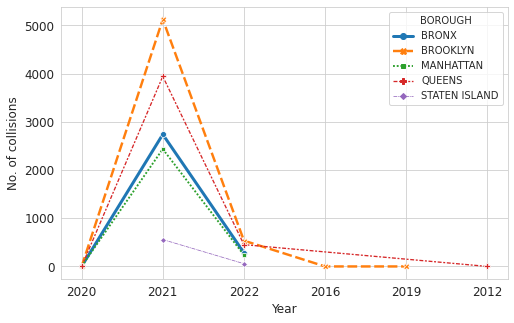

In [ ]:
# Number of collisions - Yearly trend by boroughs
def lineplots(data,groupby_rows,metric,x_axis,y_axis,xlabel,ylabel,variable = None,axis_ticks_size = 12,axis_label_size=12,Title = None,Title_size=15):
    plt.figure(figsize=(8,5))
    data=data.groupby(groupby_rows,as_index=False)[metric].count()
    sns.lineplot(data = data, x = x_axis, y = y_axis,hue = variable, markers= True,style = variable, size = variable)
    plt.xlabel(xlabel,fontsize=axis_label_size)
    plt.ylabel(ylabel,fontsize=axis_label_size)
    plt.xticks(fontsize=axis_ticks_size)
    plt.yticks(fontsize=axis_ticks_size)
    plt.title(Title,fontsize=Title_size)
lineplots(data=data,groupby_rows=['BOROUGH','year'],metric= 'COLLISION_ID',
          x_axis='year',y_axis='COLLISION_ID',variable='BOROUGH',xlabel='Year',ylabel='No. of collisions')

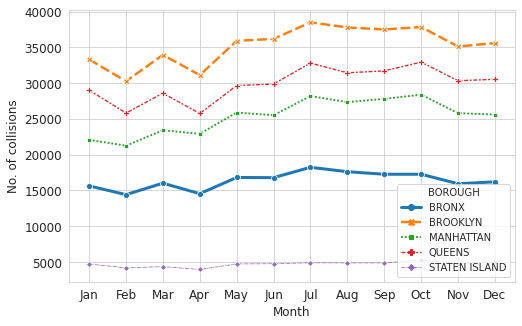

In [ ]:

lineplots(data=data,groupby_rows=['BOROUGH','month'],metric= 'COLLISION_ID',
          x_axis='month',y_axis='COLLISION_ID',variable='BOROUGH',xlabel='Month',ylabel='No. of collisions');
plt.xticks(np.sort(data.month.unique()),
           ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'));

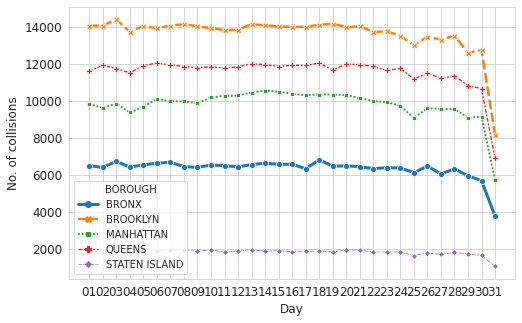

In [ ]:
#hour of day 

lineplots(data=data,groupby_rows=['BOROUGH','day'],metric= 'COLLISION_ID',
          x_axis='day',y_axis='COLLISION_ID',variable='BOROUGH',xlabel='Day',ylabel='No. of collisions')
plt.xticks(np.sort(data.day.unique()));

In [ ]:
# Temporal Analysis

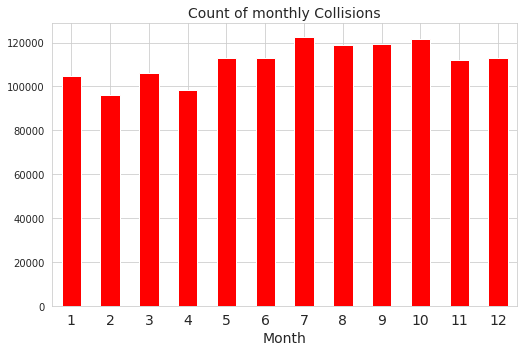

In [ ]:
# Classifying based on months, days and hours
weekday_count = data.groupby('month')['BOROUGH'].count()
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='red')
plt.title('Count of monthly Collisions', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.tight_layout()
plt.show()

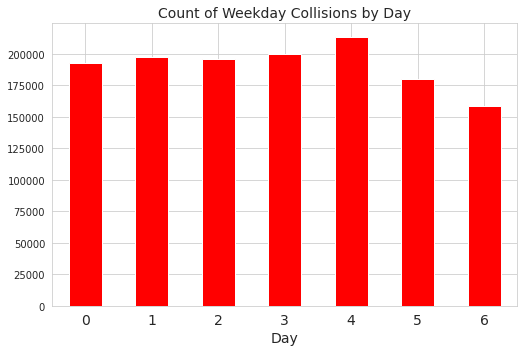

In [ ]:
#plotting Collisions by days
weekday_count = data.groupby('weekday')['BOROUGH'].count()
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='red')
plt.title('Count of Weekday Collisions by Day', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day',fontsize=14)
plt.tight_layout()
plt.show()

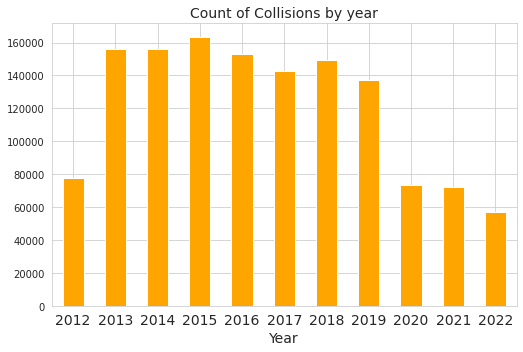

In [ ]:
plt.figure(figsize=(14, 5))
year_count = data.groupby('year')['BOROUGH'].count()
plt.subplot(122)
year_count.plot(kind='bar', color=['orange'])
plt.title('Count of Collisions by year', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Year',fontsize=14)

plt.tight_layout()
plt.show()

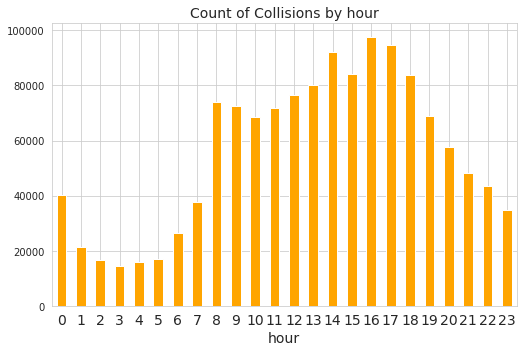

In [ ]:
# by hour
plt.figure(figsize=(14, 5))
hour_count = data.groupby('hour')['BOROUGH'].count()
plt.subplot(122)
hour_count.plot(kind='bar', color='orange')
plt.title('Count of Collisions by hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('hour',fontsize=14)

plt.tight_layout()
plt.show()

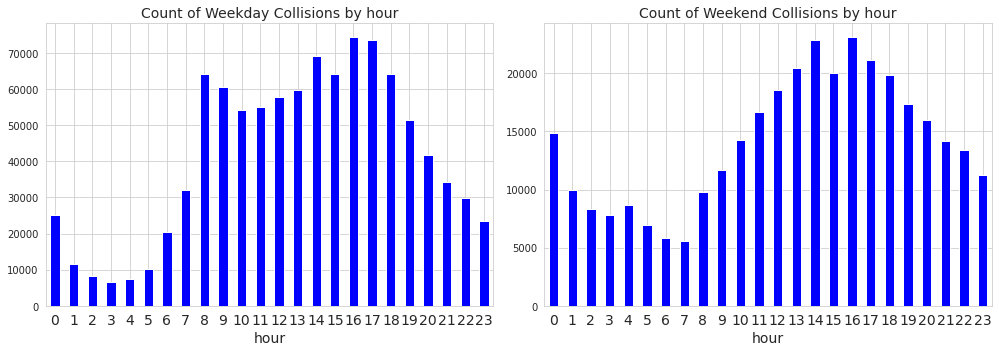

In [ ]:
weekday_count = data[data['notweekend']==True].groupby('hour')['BOROUGH'].count()
weekend_count = data[data['notweekend']==False].groupby('hour')['BOROUGH'].count()
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='blue')
plt.title('Count of Weekday Collisions by hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('hour',fontsize=14)

plt.subplot(122)
weekend_count.plot(kind='bar', color='blue')
plt.title('Count of Weekend Collisions by hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('hour',fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
weekday_count = data[data['notweekend']==True].groupby('weekday')['BOROUGH'].count()
weekend_count = data[data['notweekend']==False].groupby('weekday')['BOROUGH'].count()

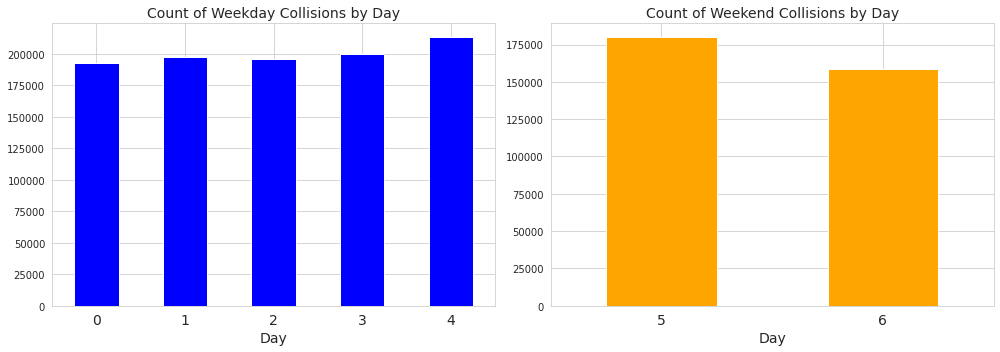

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='blue')
plt.title('Count of Weekday Collisions by Day', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day',fontsize=14)

plt.subplot(122)
weekend_count.plot(kind='bar', color='orange')
plt.title('Count of Weekend Collisions by Day', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day',fontsize=14)

plt.tight_layout()
plt.show()

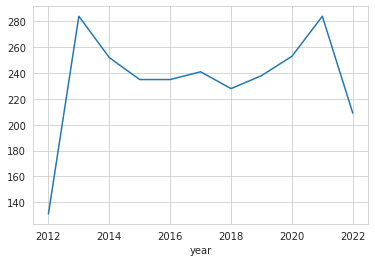

In [ ]:

# Collision Classification

fatal_by_year = data.groupby('year')['fatal'].sum()
serious_by_year =data.groupby('year')['serious'].sum()
ped_death_by_year = data.groupby('year')['ped_death'].sum()
ped_serious_by_year = data.groupby('year')['ped_serious'].sum()
fatal_by_year.plot()


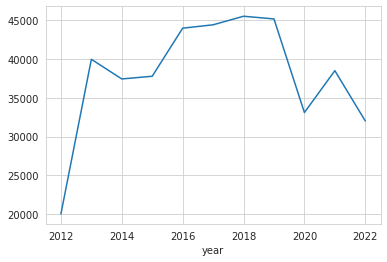

In [ ]:
serious_by_year
serious_by_year.plot()


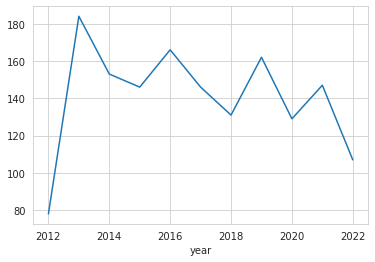

In [ ]:


ped_death_by_year.plot()


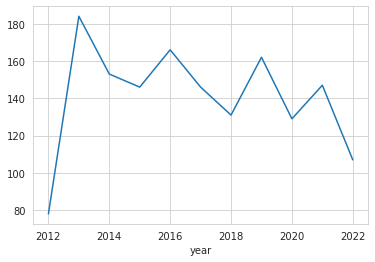

In [ ]:
ped_death_by_year.plot()

In [ ]:
collisions_by_year = data.groupby('year')['timestamp'].count()
collisions_by_year



year
2012    100545
2013    203734
2014    206033
2015    217694
2016    229831
2017    231007
2018    231564
2019    211486
2020    112914
2021    110541
2022     85666
Name: timestamp, dtype: int64

##Trends

1. Serious collisions trended between 2013 to 2019
2. Collisions dropped sharply in 2020 in response to COVID-19 and reduced travel
3. Most collisions occurred in the evening
4. Collisions are least during late night hours on weekdays but are significant on weekends.
5. Serious collisions climbed upwards from 2013 to 2019
6. Serious collisions and collisions with pedestrians and cyclists did not drop as much as overall collisions, indicating that the average collision in 2020 and 2021 was more dangerous for roadside pedestrians
7. The collisions ins 2020 and 2021 caused fatalities which were the highest since 2013



In [ ]:

collision_id_report = ph.SeriesProfile(data["COLLISION_ID"])
collision_id_report

COLLISION_ID Info
-------------------  -----
Data Type            int64
Count                25000
Unique Values        25000
Null Values          0

  Value    Count  % of total
-------  -------  ------------
4455765        1  0.00%
4416000        1  0.00%
4415639        1  0.00%
4417207        1  0.00%
4415505        1  0.00%
4415644        1  0.00%
4415867        1  0.00%
4415847        1  0.00%
4417083        1  0.00%
4416189        1  0.00%
4415589        1  0.00%
4416589        1  0.00%
4416444        1  0.00%
4414818        1  0.00%
4416544        1  0.00%
4415768        1  0.00%
4416874        1  0.00%
4415564        1  0.00%
4415268        1  0.00%
4416929        1  0.00%
4485676        1  0.00%
4485640        1  0.00%
4485014        1  0.00%
4485338        1  0.00%
4489888        1  0.00%

Statistic                            Value
-------------------------  ---------------
count                      25000
min                            4.13699e+06
1%                         

In [ ]:
data.describe()

,LATITUDE,LONGITUDE,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,weekday,hour,serious,fatal,ped_death,ped_serious
count,22973.000000,22973.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000
mean,40.526032,-73.555523,0.474000,0.00320,0.068200,0.001360,0.045880,0.000200,0.345760,0.001480,4.446269e+06,3.052760,12.878360,0.35064,0.003000,0.001520,0.110640
std,2.837824,5.149240,0.800593,0.06058,0.261288,0.036854,0.213018,0.014141,0.776192,0.043335,3.801137e+04,1.981972,6.304522,0.47718,0.054691,0.038958,0.313692
min,0.000000,-74.250150,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.136992e+06,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,40.665558,-73.961760,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.413737e+06,1.000000,8.000000,0.00000,0.000000,0.000000,0.000000
50%,40.713760,-73.919975,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.420130e+06,3.000000,14.000000,0.00000,0.000000,0.000000,0.000000
75%,40.785830,-73.867530,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.462134e+06,5.000000,18.000000,1.00000,0.000000,0.000000,0.000000
max,40.912827,0.000000,18.000000,3.00000,3.000000,1.000000,3.000000,1.000000,18.000000,3.000000,4.573583e+06,6.000000,23.000000,1.00000,1.000000,1.000000,1.000000


Collision_ID is the primary key according to the dataset dictionary. We confirm that all its values are unique.

In [ ]:
time_report = ph.SeriesProfile(data["crash_time"])
date_report = ph.SeriesProfile(data["crash_date"])
time_report, date_report


(crash_time Info
 -----------------  ------
 Data Type          object
 Count              25000
 Unique Values      1431
 Null Values        0
 
 Value      Count  % of total
 -------  -------  ------------
 0:00         437  1.75%
 15:00        307  1.23%
 17:00        263  1.05%
 14:00        253  1.01%
 16:00        249  1.00%
 18:00        233  0.93%
 12:00        221  0.88%
 8:00         220  0.88%
 13:00        205  0.82%
 9:00         201  0.80%
 11:00        195  0.78%
 14:30        191  0.76%
 17:30        190  0.76%
 10:00        183  0.73%
 15:30        178  0.71%
 19:00        176  0.70%
 16:30        174  0.70%
 18:30        166  0.66%
 20:00        164  0.66%
 21:00        160  0.64%
 3:38           1  0.00%
 1:44           1  0.00%
 2:31           1  0.00%
 6:56           1  0.00%
 2:08           1  0.00%
 
 
 , crash_date Info
 -----------------  ------
 Data Type          object
 Count              25000
 Unique Values      376
 Null Values        0
 
 Value         C

In [ ]:
loc_report = ph.SeriesProfile(data["LOCATION"])
lat_report = ph.SeriesProfile(data["LATITUDE"])
long_report = ph.SeriesProfile(data["LONGITUDE"])
loc_report, lat_report, long_report

(LOCATION Info
 ---------------  ------
 Data Type        object
 Count            22973
 Unique Values    17211
 Null Values      2027
 
 Value                      Count  % of total
 -----------------------  -------  ------------
 (0.0, 0.0)                   112  0.49%
 (40.658577, -73.89063)        17  0.07%
 (40.66496, -73.82226)         14  0.06%
 (40.69168, -73.999344)        13  0.06%
 (40.817795, -73.89319)        11  0.05%
 (40.826275, -73.85971)        11  0.05%
 (40.820305, -73.89083)        11  0.05%
 (40.64254, -73.87652)         10  0.04%
 (40.675735, -73.89686)        10  0.04%
 (40.63413, -73.928505)         9  0.04%
 (40.665257, -73.739555)        9  0.04%
 (40.861862, -73.91282)         9  0.04%
 (40.820187, -73.890686)        9  0.04%
 (40.84519, -73.9112)           9  0.04%
 (40.861862, -73.91275)         9  0.04%
 (40.8047, -73.91243)           9  0.04%
 (40.84434, -73.91475)          9  0.04%
 (40.71997, -73.992905)         9  0.04%
 (40.66895, -73.9339)         

In [ ]:
injured_report = ph.SeriesProfile(data["number_of_persons_injured"])
pedestrian_injured_report = ph.SeriesProfile(data["number_of_pedestrians_injured"])
cyclist_injured_report = ph.SeriesProfile(data["NUMBER OF CYCLIST INJURED"])
motorist_injured_report = ph.SeriesProfile(data["NUMBER OF MOTORIST INJURED"])
injured_report, pedestrian_injured_report, cyclist_injured_report, motorist_injured_report

(number_of_persons_injured Info
 --------------------------------  -------
 Data Type                         float64
 Count                             25000
 Unique Values                     11
 Null Values                       0
 
   Value    Count  % of total
 -------  -------  ------------
       0    16212  64.85%
       1     6785  27.14%
       2     1350  5.40%
       3      416  1.66%
       4      145  0.58%
       5       54  0.22%
       6       22  0.09%
       7        8  0.03%
       9        5  0.02%
       8        2  0.01%
      18        1  0.00%
 
 Statistic                         Value
 -------------------------  ------------
 count                      25000
 min                            0
 1%                             0
 5%                             0
 25%                            0
 50%                            0
 75%                            1
 95%                            2
 99%                            3
 max                           18
 

In [ ]:
killed_report = ph.SeriesProfile(data["number_of_persons_killed"])
pedestrian_killed_report = ph.SeriesProfile(data["number_of_pedestrians_killed"])
cyclist_killed_report = ph.SeriesProfile(data["NUMBER OF CYCLIST KILLED"])
motorist_killed_report = ph.SeriesProfile(data["NUMBER OF MOTORIST KILLED"])
killed_report, pedestrian_killed_report, cyclist_killed_report, motorist_killed_report

(number_of_persons_killed Info
 -------------------------------  -------
 Data Type                        float64
 Count                            25000
 Unique Values                    4
 Null Values                      0
 
   Value    Count  % of total
 -------  -------  ------------
       0    24925  99.70%
       1       71  0.28%
       2        3  0.01%
       3        1  0.00%
 
 Statistic                          Value
 -------------------------  -------------
 count                      25000
 min                            0
 1%                             0
 5%                             0
 25%                            0
 50%                            0
 75%                            0
 95%                            0
 99%                            0
 max                            3
 median                         0
 mean                           0.0032
 median absolute deviation      0
 standard deviation             0.0605798
 skew                          21

In [ ]:
data.columns


Index(['crash_date', 'crash_time', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'date', 'year', 'weekday', 'notweekend', 'timestamp', 'hour', 'serious',
       'fatal', 'ped_death', 'ped_serious'],
      dtype='object')

In [ ]:
vtype1_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 1"])
vtype2_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 2"])
vtype3_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 3"])
vtype4_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 4"])
vtype5_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 5"])
vtype1_report, vtype2_report, vtype3_report, vtype4_report, vtype5_report

(VEHICLE TYPE CODE 1 Info
 --------------------------  -------
 Data Type                   object
 Count                       1929558
 Unique Values               1445
 Null Values                 11457
 
 Value                                  Count  % of total
 -----------------------------------  -------  ------------
 Sedan                                 514940  26.69%
 PASSENGER VEHICLE                     416206  21.57%
 Station Wagon/Sport Utility Vehicle   406811  21.08%
 SPORT UTILITY / STATION WAGON         180291  9.34%
 Taxi                                   47982  2.49%
 4 dr sedan                             40132  2.08%
 TAXI                                   31911  1.65%
 Pick-up Truck                          31668  1.64%
 VAN                                    25266  1.31%
 OTHER                                  22967  1.19%
 Box Truck                              22191  1.15%
 UNKNOWN                                19935  1.03%
 Bus                                

In [ ]:


annual = pd.DataFrame()
annual["Collisions"] = data.groupby(by=data["year"])["COLLISION_ID"].count()
annual["Injured"] = data.groupby(by=data["year"])[
    "number_of_persons_injured"
].sum()
annual["Deaths"] = data.groupby(by=data["year"])[
    "number_of_persons_killed"
].sum()



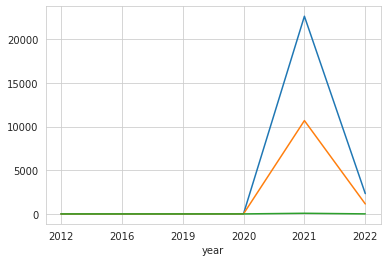

In [ ]:
annual["Collisions"].plot()
annual["Injured"].plot()
annual["Deaths"].plot()


In [ ]:
data["crash_date"].min(), data["crash_date"].max()

('01/01/2013', '12/31/2021')


- 


In [ ]:
boroughList = data.groupby(['BOROUGH']).size().reset_index(name='NoOfAccidents')
boroughList.head()

,BOROUGH,NoOfAccidents
0,BRONX,196660
1,BROOKLYN,423083
2,MANHATTAN,304151
3,QUEENS,358472
4,STATEN ISLAND,56206


In [ ]:
# Importing ShapeFile for Boundaries in NYC Boroughs

fp = '/content/drive/MyDrive/geo_export_3369efe6-1e9c-487f-9bab-0339a68ab316.shp'
geometry = gpd.read_file(fp)
geometry.head()


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623631e+09,325924.002076,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187189e+09,463277.240478,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1.0,Manhattan,6.366058e+08,359103.151368,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3.0,Brooklyn,1.934169e+09,728478.125489,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.041397e+09,888238.562635,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [ ]:
geometry['boro_name'] = geometry['boro_name'].str.upper() 

# Merging the ShapeFile with the dataset
boroughList = geometry.set_index('boro_name').join(boroughList.set_index('BOROUGH'))

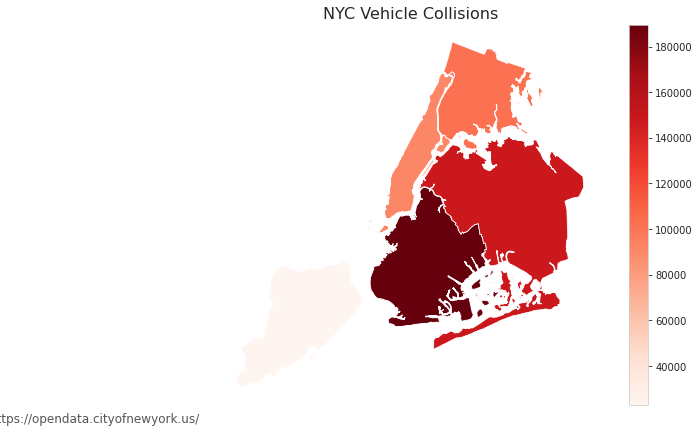

In [ ]:
# Defining the Matplotlib with respoective figure and axes
fig, ax = plt.subplots(1, figsize=(10, 7))

# Plotting the Map 
boroughList.plot(column = 'NoOfAccidents', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax, edgecolor = '1')

# Customizing the Map with Titles and Annotations
ax.axis('off')
ax.set_title('NYC Vehicle Collisions', size = 16)
ax.annotate('Source: https://opendata.cityofnewyork.us/', xy = (0.1, .08),  
            xycoords = 'figure fraction', horizontalalignment = 'center', verticalalignment = 'top', 
            fontsize = 12, color = '#555555')

# Combining a colour bar for better distinguition in the map
sm = plt.cm.ScalarMappable(cmap = 'Reds', 
                           norm = plt.Normalize(vmin = 22822, vmax = 189648))
sm._A = []
cbar = fig.colorbar(sm)


In [ ]:
data.columns


Index(['crash_date', 'crash_time', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'date', 'year', 'weekday', 'notweekend', 'timestamp', 'hour', 'serious',
       'fatal', 'ped_death', 'ped_serious'],
      dtype='object')

In [ ]:
Causality = data.groupby(['BOROUGH'])\
['number_of_persons_killed', 'number_of_persons_injured'].agg('sum').reset_index()
Causality['Total Accidents'] = data.groupby(['BOROUGH']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Casualities sorted into Number of person Injured by their Percentage.
Causality['Injury%'] = round((Causality['number_of_persons_injured']\
/ Causality['Total Accidents'] * 100), 1)
# Casualities sorted into Number of persons Killed by their Percentage.
Causality['Fatality%'] = round((Causality['number_of_persons_killed']\
/ Causality['Total Accidents'] * 100), 3)

Causality.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,BOROUGH,number_of_persons_killed,number_of_persons_injured,Total Accidents,Injury%,Fatality%
0,BRONX,5.0,1284.0,3027,42.4,0.165
1,BROOKLYN,16.0,2740.0,5666,48.4,0.282
2,MANHATTAN,8.0,1055.0,2679,39.4,0.299
3,QUEENS,6.0,1937.0,4399,44.0,0.136
4,STATEN ISLAND,2.0,296.0,617,48.0,0.324


# Insights: The borough of Staten island has reported the lowest number of accidents whereas the boroughs of Queens and Brooklyn have reported the most number of accidents when compared to other boroughs in NYC.


In [ ]:
# Reducing redudant data by removing coloum and collaborating data with the Shapefile
Causality.drop('Total Accidents', axis = 1, inplace = True)
Causality = geometry.set_index('boro_name').join(Causality.set_index('BOROUGH'))

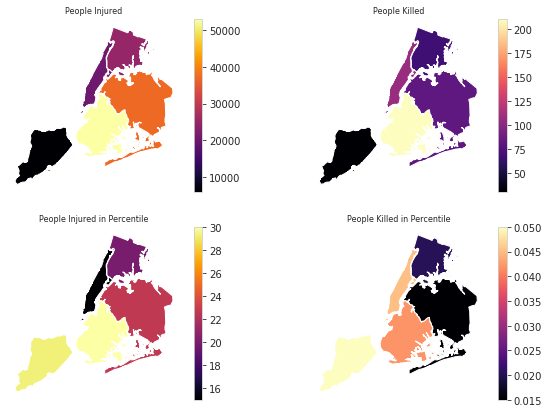

In [ ]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 7))

# Drawing map for Persons Injured
Causality.plot(column = 'number_of_persons_injured', cmap = 'inferno', linewidth = 1, 
                      ax = ax1, edgecolor = '1')
# Drawing map for Persons Killed
Causality.plot(column = 'number_of_persons_killed', cmap = 'magma', linewidth = 1, 
                      ax = ax2, edgecolor = '1')
# Drawing map for Persons Injured in Percentage
Causality.plot(column = 'Injury%', cmap = 'inferno', linewidth = 1, 
                      ax = ax3, edgecolor = '1')
# Drawing map for Persons Killed in Percentage
Causality.plot(column = 'Fatality%', cmap = 'magma', linewidth = 1, 
                      ax = ax4, edgecolor = '1')

# Map customizations
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax1.set_title('People Injured', size = 8)
ax2.set_title('People Killed', size = 8)
ax3.set_title('People Injured in Percentile', size = 8)
ax4.set_title('People Killed in Percentile', size = 8)

# Adding color bar legends to the maps
sm = plt.cm.ScalarMappable(cmap = 'inferno', norm = plt.Normalize(vmin = 5800, vmax = 53000))
sm._A = []
cbar = fig.colorbar(sm, ax = ax1)

sm = plt.cm.ScalarMappable(cmap = 'magma', norm = plt.Normalize(vmin = 30, vmax = 210))
sm._A = []
cbar = fig.colorbar(sm, ax = ax2)

sm = plt.cm.ScalarMappable(cmap = 'inferno', norm = plt.Normalize(vmin = 15, vmax = 30))
sm._A = []
cbar = fig.colorbar(sm, ax = ax3)

sm = plt.cm.ScalarMappable(cmap = 'magma', norm = plt.Normalize(vmin = 0.05, vmax = 0.015))
sm._A = []
cbar = fig.colorbar(sm, ax = ax4)



Insights : Queens, Staten Island, Bronx and Brooklyn show a very high percentile of accidents which lead to injury, whereas Manhattan has shown the least number of accidents when compared to other boroughs in NYC.

###**Machine learning algorithms to predict whether the location is safe for the pedestrians or not **

code cleaning

In [ ]:
df1 = data
import math
x = float("NaN")
rows = []
for i in range(len(df1)):
  if math.isnan(df1['LATITUDE'][i]) or math.isnan(df1['LONGITUDE'][i]) or pd.isna(df1['crash_time'][i]):
    rows.append(i)


df2 = df1.drop(rows, axis=0)

In [ ]:
df2.head()

,crash_date,crash_time,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,day,weekday,month,notweekend,timestamp,hour,serious,fatal,ped_death,ped_serious
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,11,5,9,False,2021-09-11 09:35:00,9,0,0,0,0
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,14,1,12,True,2021-12-14 08:13:00,8,0,0,0,0
6,12/14/2021,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,14,1,12,True,2021-12-14 17:05:00,17,0,0,0,0
7,12/14/2021,8:17,BRONX,10475,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,14,1,12,True,2021-12-14 08:17:00,8,1,0,0,0
8,12/14/2021,21:10,BROOKLYN,11207,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,14,1,12,True,2021-12-14 21:10:00,21,0,0,0,0


###**Feature Engineering**

In [ ]:
#convert time and latitude longitude
#create classes for seasons months march april may  - spring (1), dec ,jan, feb march - winter(0), sep, oct, nov - fall(2), summer june july august 
#morning 6 to 12 class 0 afternoon 12 to 6 class 1 night 6pm to 6am class 2
time_column = []
morning_start = 60 * 6
morning_end = 60 * 12
afternoon_start = 60 * 13
afternoon_end = 60 * 17
night_start = 60 * 18
night_end = 60 * 6
lat_data = []
long_data = []
location_safety = []
season = []
for i in range(len(df1)):
  time_split= df1['crash_time'][i].split(':')
  curr_time = int(time_split[0]) * 60 + int(time_split[1])
  df1['LATITUDE'][i] = round(df1['LATITUDE'][i], 2)
  df1['LONGITUDE'][i] = round(df1['LONGITUDE'][i], 2)
  if (df1['month'][i] >= 1 and df1['month'][i]  <= 3) or df1['month'][i]  == 12:
    season.append(0)
  elif df1['month'][i]  <= 5:
    season.append(1)
  elif df1['month'][i] <= 8:
    season.append(2)
  else:
    season.append(3)
  
  if curr_time >= morning_start and curr_time <= morning_end:
    time_column.append(0)
  elif curr_time > morning_end and curr_time <= afternoon_end:
    time_column.append(1)
  else:
    time_column.append(2)
  if int(df1['ped_death'][i]) == 0 and int(df1['ped_serious'][i] == 0):
    location_safety.append(1)
  else:
    location_safety.append(0)
df1['crash_time_class'] = time_column
df1['location_safety'] = location_safety
df1['season'] = season
df2 = df1.drop(rows)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df2

,crash_date,crash_time,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,weekday,month,notweekend,serious,fatal,ped_death,ped_serious,crash_time_class,location_safety,season
3,09/11/2021,9:35,BROOKLYN,11208,40.67,-73.87,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,5,9,False,0,0,0,0,0,1,3
4,12/14/2021,8:13,BROOKLYN,11233,40.68,-73.92,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,1,12,True,0,0,0,0,0,1,0
6,12/14/2021,17:05,NaN,NaN,40.71,-73.96,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,1,12,True,0,0,0,0,2,1,0
7,12/14/2021,8:17,BRONX,10475,40.87,-73.83,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,1,12,True,1,0,0,0,0,1,0
8,12/14/2021,21:10,BROOKLYN,11207,40.67,-73.90,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,1,12,True,0,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,12/08/2021,19:00,NaN,NaN,40.78,-73.91,"(40.77613, -73.910706)",31 STREET,NaN,NaN,...,2,12,True,0,0,0,0,2,1,0
24996,12/26/2021,4:45,QUEENS,11418,40.69,-73.84,"(40.689873, -73.84282)",ATLANTIC AVENUE,102 STREET,NaN,...,6,12,False,0,0,0,0,2,1,0
24997,12/25/2021,16:45,QUEENS,11102,40.77,-73.92,"(40.766884, -73.921394)",31 STREET,30 AVENUE,NaN,...,5,12,False,1,0,0,1,1,0,0
24998,12/26/2021,10:59,BROOKLYN,11229,40.60,-73.94,"(40.603203, -73.937584)",AVENUE T,COYLE STREET,NaN,...,6,12,False,0,0,0,0,0,1,0


split the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
df = df2[['crash_time_class','LATITUDE', 'LONGITUDE', 'season', 'location_safety']]
target = 'location_safety'
# Create arrays for the features and the response variable
# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [ ]:
df.head()

,crash_time_class,LATITUDE,LONGITUDE,season,location_safety
3,0,40.67,-73.87,3,1
4,0,40.68,-73.92,0,1
6,2,40.71,-73.96,0,1
7,0,40.87,-73.83,0,1
8,2,40.67,-73.90,0,1


###**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))


[Logistic regression algorithm] accuracy_score: 0.924.


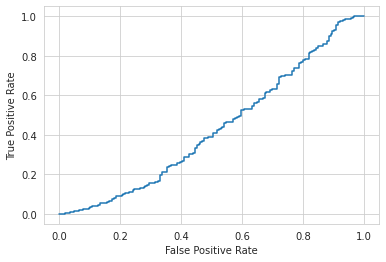

In [ ]:
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

confusion matrix for logistic regression


In [ ]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[     0,  27674],
       [     0, 315771]])

###**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
print(acc)


0.9287356321839081


confusion matrix for KNN

0.9287356321839081


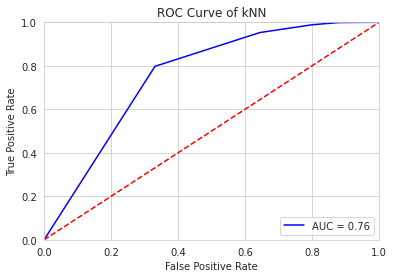

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt



y_scores = knn.predict_proba(X_test)
acc=accuracy_score(y_test, y_pred)
print(acc)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[   509,  27165],
       [  3930, 311841]])

In [ ]:
from sklearn.model_selection import train_test_split
df3 = df2[['LATITUDE', 'LONGITUDE', 'month']]
df3['Counts'] = np.zeros(len(df3))
df4 = df3.groupby(['LATITUDE', 'LONGITUDE'])['month'].value_counts().reset_index(name='counts')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
hotspot = []
for i in range(len(df4)):
  if df4['counts'][i] >= 6:
    hotspot.append(1) #accident hotspot
  else:
    hotspot.append(0) #not an accident hotspot

df4['hotspot'] = hotspot

In [ ]:
from sklearn.model_selection import train_test_split
df = df4[['LATITUDE', 'LONGITUDE', 'hotspot', 'month']]
target = 'hotspot'
# Create arrays for the features and the response variable
# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))


[Logistic regression algorithm] accuracy_score: 0.924.


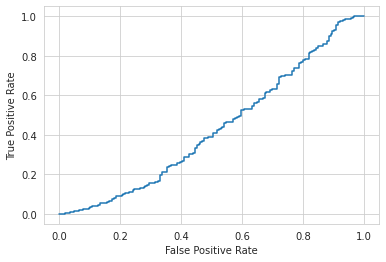

In [ ]:
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
print(acc)
